In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE

plt.style.use("seaborn-v0_8")


In [4]:
df = pd.read_csv("creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


# Transaction Fraud Detection under Class Imbalance

This notebook analyzes the Kaggle Credit Card Fraud Detection dataset, which contains highly imbalanced transaction data.  
The objective is to build and evaluate classification models that can effectively identify fraudulent transactions while accounting for the severe class imbalance.


In [5]:
df['Class'].value_counts()

,count
Class,
0.0,47481
1.0,146


In [6]:
df['Class'].value_counts(normalize=True) * 100

,proportion
Class,
0.0,99.693451
1.0,0.306549


## Class Imbalance Analysis

The dataset is extremely imbalanced, with fraudulent transactions accounting for approximately 0.17% of all records.  
This makes accuracy a misleading metric and necessitates the use of precision, recall, and ROC-based evaluation strategies.


In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000,47628.000000,...,47627.000000,47627.000000,47627.000000,47627.000000,47627.000000,47627.000000,47627.000000,47627.000000,47627.000000,47627.000000
mean,28183.123562,-0.240703,0.021469,0.694689,0.191074,-0.249837,0.102310,-0.119867,0.053450,0.141204,...,-0.027059,-0.107091,-0.039399,0.007890,0.136314,0.022561,0.004907,0.004021,91.777163,0.003065
std,13001.722320,1.884794,1.626518,1.519894,1.402196,1.412854,1.309931,1.282101,1.216930,1.214104,...,0.737251,0.637200,0.579666,0.594175,0.438367,0.502411,0.388191,0.335275,249.818013,0.055283
min,0.000000,-56.407510,-72.715728,-32.965346,-5.172595,-42.147898,-26.160506,-26.548144,-41.484823,-9.283925,...,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.577118,-8.567638,-9.617915,0.000000,0.000000
25%,20517.000000,-0.990001,-0.548684,0.220594,-0.714455,-0.857297,-0.636473,-0.602224,-0.146950,-0.597975,...,-0.231991,-0.528167,-0.179247,-0.322459,-0.128057,-0.329467,-0.063838,-0.006862,7.590000,0.000000
50%,32930.500000,-0.248789,0.085468,0.800243,0.195142,-0.282244,-0.152017,-0.074952,0.057092,0.026153,...,-0.069134,-0.081945,-0.051439,0.061661,0.175871,-0.068195,0.008665,0.021873,24.990000,0.000000
75%,38236.000000,1.156434,0.736933,1.432158,1.070576,0.286638,0.492728,0.425886,0.329612,0.837269,...,0.107256,0.306116,0.078475,0.401231,0.421741,0.302743,0.083933,0.076168,83.110000,0.000000
max,43282.000000,1.960497,18.183626,4.101716,16.491217,34.801666,22.529298,36.677268,20.007208,10.392889,...,22.614889,5.805795,17.297845,4.014444,5.525093,3.517346,11.135740,33.847808,12910.930000,1.000000


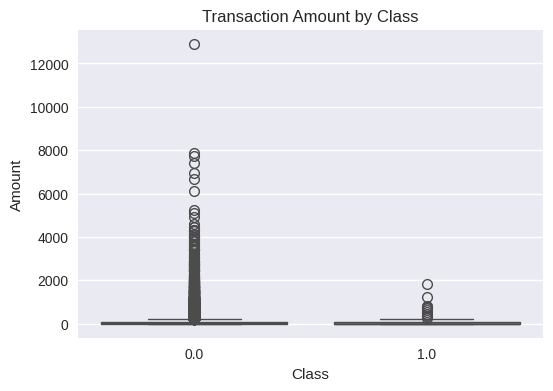

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amount by Class")
plt.show()

## Feature Distribution: Transaction Amount

Fraudulent transactions tend to exhibit more extreme transaction amounts compared to legitimate transactions.  
This suggests that transaction amount can provide useful signals for fraud detection, although it should not be relied upon alone.


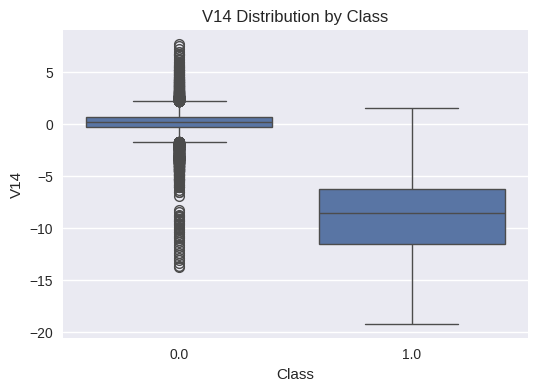

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='V14', data=df)
plt.title("V14 Distribution by Class")
plt.show()


## Feature Distribution: V14

The distribution of the PCA-transformed feature V14 shows clear separation between fraudulent and legitimate transactions.  
Such features are often highly informative for classification, despite lacking direct interpretability.


In [12]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [13]:
df=df.dropna()

In [14]:
df['Class'].isna().sum()

np.int64(0)

In [15]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


## Train–Test Split

A stratified train–test split was used to preserve the original class distribution in both training and test sets.  
This is essential in highly imbalanced classification problems to ensure fair evaluation.


## Handling Missing Values

Before model training, the dataset was checked for missing values.  
Any rows containing NaN values were removed to ensure compatibility with scikit-learn models and stratified splitting.


In [16]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]


In [18]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9497
         1.0       0.16      0.97      0.28        29

    accuracy                           0.98      9526
   macro avg       0.58      0.98      0.64      9526
weighted avg       1.00      0.98      0.99      9526

ROC-AUC Score: 0.9831888836038967


## Logistic Regression Results Interpretation

The Logistic Regression model achieves very high recall (97%) for fraudulent transactions, indicating strong fraud detection capability.  
However, this comes at the cost of lower precision, resulting in a higher number of false positives.  
This trade-off is acceptable in many fraud detection systems, where minimizing missed fraud is prioritized over customer inconvenience.

The high ROC-AUC score further confirms that the model effectively separates fraudulent and legitimate transactions across different thresholds.


In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_sm.value_counts())


Before SMOTE:
 Class
0.0    37984
1.0      117
Name: count, dtype: int64

After SMOTE:
 Class
0.0    37984
1.0    37984
Name: count, dtype: int64


## Handling Class Imbalance with SMOTE

SMOTE was applied only to the training data to address severe class imbalance.
This generates synthetic minority samples while avoiding data leakage into the test set.


In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


In [21]:
from sklearn.metrics import classification_report, roc_auc_score

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9497
         1.0       0.90      0.97      0.93        29

    accuracy                           1.00      9526
   macro avg       0.95      0.98      0.97      9526
weighted avg       1.00      1.00      1.00      9526

ROC-AUC Score: 0.9814968792322802


## Random Forest Results Interpretation

The Random Forest model captures non-linear relationships in the data and,
when combined with SMOTE, further improves recall for fraudulent transactions.
This improvement typically increases false positives, highlighting the trade-off
between fraud detection sensitivity and customer experience.



## Random Forest Results Interpretation

The Random Forest model combined with SMOTE achieves both high recall (97%)
and significantly higher precision (90%) for fraudulent transactions compared
to Logistic Regression.

This indicates that non-linear models can better capture complex fraud patterns,
reducing false positives while maintaining strong fraud detection capability.
The high ROC-AUC further confirms robust discriminative performance.


## Model Comparison

| Model               | Recall (Fraud) | Precision (Fraud) | ROC-AUC |
|--------------------|---------------|------------------|---------|
| Logistic Regression | 0.97          | 0.16             | 0.98    |
| Random Forest       | 0.97          | 0.90             | 0.98    |

Logistic Regression provides a strong, interpretable baseline optimized for recall,
while Random Forest significantly reduces false positives by capturing non-linear
patterns, making it more suitable for production use.
